### Data Loading

In [ ]:
import pandas as pd
import openai
import faiss
import numpy as np

# Set your OpenAI API Key
openai.api_key = "your-openai-key"

In [2]:
# Load patient dataset
df = pd.read_csv("./80-20-llm-data/llm_train_filtered.csv")
df.head()

,llm_patient_narrative,label
0,A 61-year-old f patient experienced the sympto...,likely related
1,A 61-year-old f patient experienced the sympto...,likely related
2,A 10-year-old f patient experienced the sympto...,unlikely related
3,A 18-year-old f patient experienced the sympto...,likely related
4,A 10-year-old m patient experienced the sympto...,likely related


In [3]:
# Define embedding function for new OpenAI API 
def get_embedding(text, model="text-embedding-ada-002"):
    # To avoid exceeding token limits, truncate very long texts
    if len(text) > 7000:  # Rough cutoff (about 7000 characters)
        text = text[:7000]
    
    response = openai.embeddings.create(
        input=[text],
        model=model
    )
    return response.data[0].embedding

# Initialize empty list
embeddings = []

# Go through your dataset carefully
for i, row in df.iterrows():
    narrative = row['llm_patient_narrative']

    if isinstance(narrative, str) and narrative.strip() != "":  # Extra safety check
        emb = get_embedding(narrative)
        embeddings.append(emb)
    else:
        # If narrative is empty, store a dummy zero vector (same dimension as normal embeddings)
        embeddings.append([0.0] * 1536)  # 1536 is the embedding dimension of ada-002

    if i % 50 == 0:
        print(f"Embedded {i} examples...")

# Convert to numpy array
embeddings = np.array(embeddings)

print(f"Created embeddings for {len(embeddings)} narratives!")


Embedded 0 examples...
Embedded 50 examples...
Embedded 100 examples...
Embedded 150 examples...
Embedded 200 examples...
Embedded 250 examples...
Embedded 300 examples...
Embedded 350 examples...
Embedded 400 examples...
Embedded 450 examples...
Embedded 500 examples...
Embedded 550 examples...
Embedded 600 examples...
Embedded 650 examples...
Embedded 700 examples...
Embedded 750 examples...
Embedded 800 examples...
Embedded 850 examples...
Embedded 900 examples...
Embedded 950 examples...
Embedded 1000 examples...
Embedded 1050 examples...
Embedded 1100 examples...
Embedded 1150 examples...
Embedded 1200 examples...
Embedded 1250 examples...
Embedded 1300 examples...
Embedded 1350 examples...
Embedded 1400 examples...
Embedded 1450 examples...
Embedded 1500 examples...
Embedded 1550 examples...
Embedded 1600 examples...
Embedded 1650 examples...
Embedded 1700 examples...
Embedded 1750 examples...
Embedded 1800 examples...
Created embeddings for 1846 narratives!


In [4]:
# Save embeddings to file
np.save("patient_embeddings_1846.npy", embeddings)
print("Saved embeddings to patient_embeddings_1846.npy")


Saved embeddings to patient_embeddings_1846.npy


In [5]:
# Save the narratives and labels used for these embeddings
df.iloc[:len(embeddings)].to_csv("patient_narratives_1846.csv", index=False)
print("Saved patient narratives to patient_narratives_1846.csv")

Saved patient narratives to patient_narratives_1846.csv


### Load Embeddings and Patient Narratives

In [35]:
import numpy as np
import pandas as pd
import faiss

# Load saved embeddings
embeddings = np.load("patient_embeddings_1846.npy")

# Load corresponding patient narratives
df = pd.read_csv("patient_narratives_1846.csv")

print(f"Embeddings shape: {embeddings.shape}")
print(f"Narratives shape: {df.shape}")


Embeddings shape: (1846, 1536)
Narratives shape: (1846, 2)


### FAISS Vector Database

In [36]:
# Create FAISS index
dimension = embeddings.shape[1]  # Should be 1536
index = faiss.IndexFlatL2(dimension)  # L2 = Euclidean distance

# Add embeddings into FAISS
index.add(embeddings)

print(f"FAISS index built with {index.ntotal} vectors.")


FAISS index built with 1846 vectors.


### Define a Search Function

In [37]:
# Define a function to embed user query
def embed_query(text, model="text-embedding-ada-002"):
    response = openai.embeddings.create(
        input=[text],
        model=model
    )
    return np.array(response.data[0].embedding)

# Define a function to search
def search_patient_narratives(query, k=3):
    query_emb = embed_query(query).reshape(1, -1)  # reshape for FAISS
    distances, indices = index.search(query_emb, k)
    results = df.iloc[indices[0]]['llm_patient_narrative'].tolist()
    return results

In [38]:
def ask_gpt_with_context(user_query='', k=3, model="gpt-3.5-turbo"):
    # Search for relevant patient narratives
    retrieved_narratives = search_patient_narratives(user_query, k)

    # Combine into context
    context = "\n\n".join(retrieved_narratives)

    # Build the final prompt
    final_prompt = f"Using the following patient case information:\n\n{context}\n\nAnswer this question:\n{user_query}"

    # Call OpenAI LLM
    response = openai.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful medical assistant."},
            {"role": "user", "content": final_prompt}
        ],
        temperature=0.3,
    )

    return response.choices[0].message.content


In [ ]:
user_query = "suppose , you are a doctor. I am a female patient 30 years old. i am having fever. previously 1 year ago 1 had covid. does my fever a post covid symtom. give me the answer in one word yes or not "
answer = ask_gpt_with_context(user_query, k=3)
print(answer)


### OpenAI 3.5 Turbo Test

In [40]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
import time

# Load test set
test_df = pd.read_csv("./80-20-llm-data/llm_test_filtered.csv")

# Take only the first 500 rows (we should take full test dataset for more precise results )
test_df = test_df.iloc[:500]

# Map true labels to 0/1
label_mapping = {
    "likely related": 1,
    "unlikely related": 0
}
true_labels = test_df['label'].map(label_mapping).values

# Predict
pred_llm = []
for i, narrative in enumerate(test_df['llm_patient_narrative']):
    user_query = f"Is the following patient's symptom related to post-COVID? Answer only 'yes' or 'no'.\n\n{narrative}"
    answer = ask_gpt_with_context(user_query, k=3)

    if 'yes' in answer.lower():
        pred_llm.append(1)
    else:
        pred_llm.append(0)
    
    # Optional: small sleep to avoid hitting OpenAI rate limit
    if (i + 1) % 50 == 0:
        print(f"Processed {i+1} patients...")
        time.sleep(1)

pred_llm = np.array(pred_llm)

# Evaluate
auroc_llm_openai = roc_auc_score(true_labels, pred_llm)
auprc_llm_openai = average_precision_score(true_labels, pred_llm)

Processed 50 patients...
Processed 100 patients...
Processed 150 patients...
Processed 200 patients...
Processed 250 patients...
Processed 300 patients...
Processed 350 patients...
Processed 400 patients...
Processed 450 patients...


In [50]:
print(f"LLM AUROC (500 samples): {auroc_llm_openai:.3f}, AUPRC: {auprc_llm_openai:.3f}")

LLM AUROC (500 samples): 0.533, AUPRC: 0.856


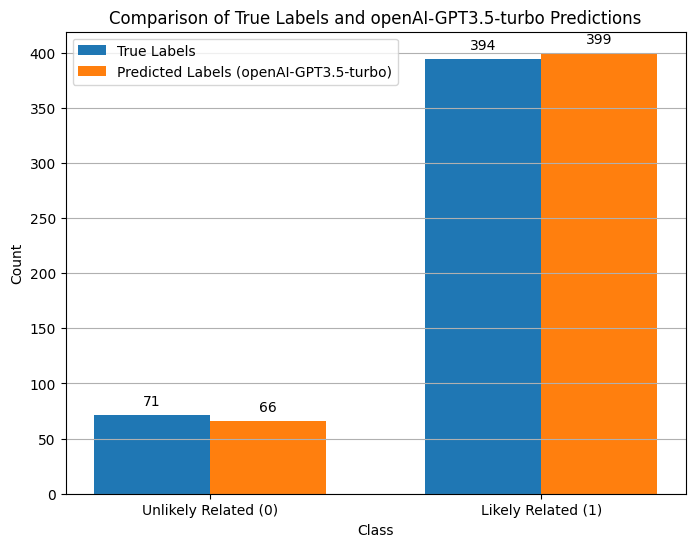

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Count values
true_counts = [np.sum(true_labels == 0), np.sum(true_labels == 1)]
pred_counts = [np.sum(pred_llm == 0), np.sum(pred_llm == 1)]

# Labels
classes = ['Unlikely Related (0)', 'Likely Related (1)']
x = np.arange(len(classes))  # the label locations
width = 0.35  # the width of the bars

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, true_counts, width, label='True Labels')
rects2 = ax.bar(x + width/2, pred_counts, width, label='Predicted Labels (LLM)')

# Add labels, title, and legend
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_title('Comparison of True Labels and LLM Predictions')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
plt.grid(axis='y')

plt.show()


### Traditional ML (Logistic Regression)

In [123]:
import pandas as pd
import os

# Load CSV files
data_path = r"C:\Users\fabli\OneDrive\Desktop\fabliha\Masters Studies\AI in Healthcare\Assignments\high_risk_project\80-20-normal-data"

test_df = pd.read_csv(os.path.join(data_path, "normal-test.csv"))
train_df = pd.read_csv(os.path.join(data_path, "normal-train.csv"))

In [146]:
test_df.shape

(937, 11)

In [133]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack


# Define features
text_features = ['DESCRIPTION', 'COMORBIDITIES', 'MEDICATIONS', 'IMMUNIZATIONS']
categorical_features = ['GENDER', 'VACCINATION_BEFORE_COVID']
numeric_features = ['days_after_recovery', 'VALUE', 'AGE']

# Encode categorical features
for col in categorical_features:
    encoder = LabelEncoder()
    train_df[col] = encoder.fit_transform(train_df[col])
    test_df[col] = encoder.transform(test_df[col])

# Vectorize text features
tfidf_vectorizers = {}
X_train_text = []
X_test_text = []

for col in text_features:
    vectorizer = TfidfVectorizer(max_features=512)  # limit features to avoid huge size
    X_train_col = vectorizer.fit_transform(train_df[col])
    X_test_col = vectorizer.transform(test_df[col])
    tfidf_vectorizers[col] = vectorizer
    
    X_train_text.append(X_train_col)
    X_test_text.append(X_test_col)

# Stack all features: numeric + categorical + text
X_train_numeric = train_df[numeric_features + categorical_features]
X_test_numeric = test_df[numeric_features + categorical_features]

# Concatenate sparse matrix (text) and dense matrix (numeric)
X_train_final = hstack(X_train_text + [X_train_numeric])
X_test_final = hstack(X_test_text + [X_test_numeric])

# Labels
y_train = train_df['post_covid_symptom']
y_test = test_df['post_covid_symptom']

# Train Logistic Regression
model = LogisticRegression(max_iter=25)
model.fit(X_train_final, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_final)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9775880469583778

Classification Report:
                   precision    recall  f1-score   support

  likely related       0.99      0.98      0.99       786
unlikely related       0.92      0.95      0.93       151

        accuracy                           0.98       937
       macro avg       0.95      0.97      0.96       937
    weighted avg       0.98      0.98      0.98       937



C:\Users\fabli\OneDrive\Desktop\fabliha\Masters Studies\AI in Healthcare\Assignments\high_risk_project\high_risk_pr_env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


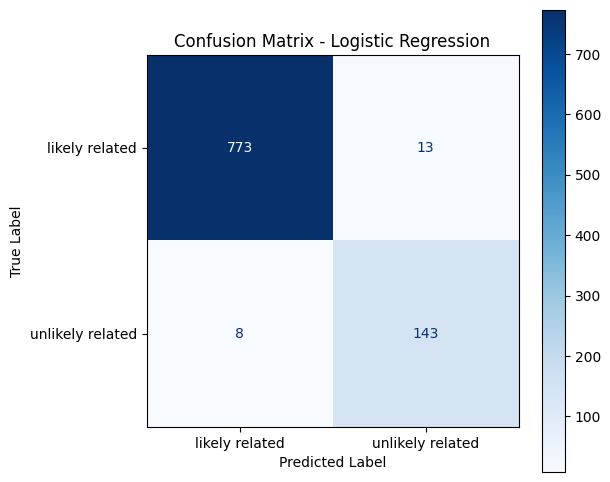

In [134]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.classes_)

disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [142]:
# Map labels for evaluation
label_mapping = {
    'unlikely related': 0,
    'likely related': 1
}
y_test_mapped = y_test.map(label_mapping)
y_pred_mapped = pd.Series(y_pred).map(label_mapping)  # map predicted labels too if needed

# Calculate evaluation metrics
auroc = roc_auc_score(y_test_mapped, y_pred_mapped)
auprc = average_precision_score(y_test_mapped, y_pred_mapped)

# Print results
print(f"AUROC Score: {auroc:.3f}")
print(f"AUPRC Score: {auprc:.3f}")

AUROC Score: 0.965
AUPRC Score: 0.987


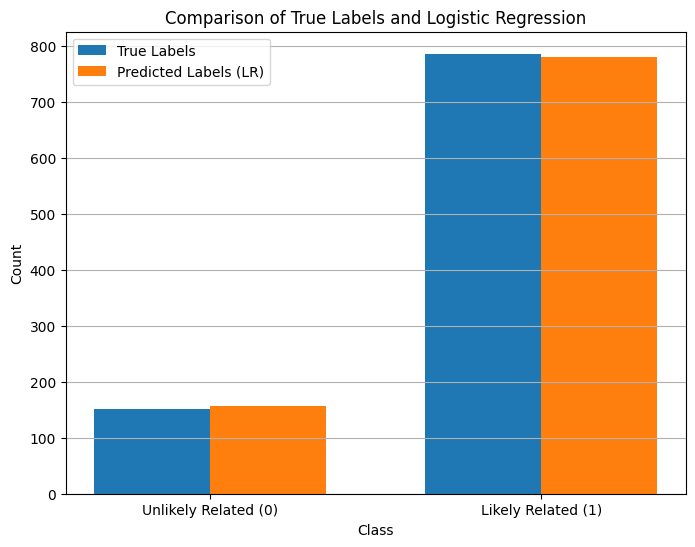

In [143]:
import matplotlib.pyplot as plt
import numpy as np

# Count values
true_counts = [np.sum(y_test == 'unlikely related'), np.sum(y_test == 'likely related')]
pred_counts = [np.sum(y_pred == 'unlikely related'), np.sum(y_pred == 'likely related')]

# Labels
classes = ['Unlikely Related (0)', 'Likely Related (1)']
x = np.arange(len(classes))  # the label locations
width = 0.35  # the width of the bars

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, true_counts, width, label='True Labels')
rects2 = ax.bar(x + width/2, pred_counts, width, label='Predicted Labels (LR)')

# Add labels, title, and legend
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_title('Comparison of True Labels and Logistic Regression')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
plt.grid(axis='y')

plt.show()



### Deepseek testing and comparison

In [43]:
import faiss
import numpy as np
import pandas as pd
import ollama
from sklearn.metrics import roc_auc_score, average_precision_score

# Load database
df = pd.read_csv("./80-20-llm-data/llm_train_filtered.csv")

# Function to get embedding (nomic-embed-text)
def get_embedding(text, model="nomic-embed-text"):
    response = ollama.embeddings(model=model, prompt=text)
    return np.array(response['embedding'])

# Rebuild embeddings for the database
print("Rebuilding database embeddings...")
database_embeddings = []
for idx, narrative in enumerate(df['llm_patient_narrative']):
    emb = get_embedding(narrative)
    database_embeddings.append(emb)
    if idx % 50 == 0:
        print(f"Embedded {idx} records...")

database_embeddings = np.array(database_embeddings)

# Build FAISS index
dimension = database_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(database_embeddings)

print(f"FAISS index built with {index.ntotal} vectors.")

Rebuilding database embeddings...
Embedded 0 records...
Embedded 50 records...
Embedded 100 records...
Embedded 150 records...
Embedded 200 records...
Embedded 250 records...
Embedded 300 records...
Embedded 350 records...
Embedded 400 records...
Embedded 450 records...
Embedded 500 records...
Embedded 550 records...
Embedded 600 records...
Embedded 650 records...
Embedded 700 records...
Embedded 750 records...
Embedded 800 records...
Embedded 850 records...
Embedded 900 records...
Embedded 950 records...
Embedded 1000 records...
Embedded 1050 records...
Embedded 1100 records...
Embedded 1150 records...
Embedded 1200 records...
Embedded 1250 records...
Embedded 1300 records...
Embedded 1350 records...
Embedded 1400 records...
Embedded 1450 records...
Embedded 1500 records...
Embedded 1550 records...
Embedded 1600 records...
Embedded 1650 records...
Embedded 1700 records...
Embedded 1750 records...
Embedded 1800 records...
FAISS index built with 1846 vectors.


In [45]:

# Load test patients
test_df = pd.read_csv("./80-20-llm-data/llm_test_filtered.csv").iloc[:50]

# Map labels
label_mapping = {
    "likely related": 1,
    "unlikely related": 0
}
true_labels_ds = test_df['label'].map(label_mapping).values

# Define function: retrieve + build RAG prompt + ask DeepSeek-R1
def rag_deepseek_answer(query_text, k=3):
    # Embed query
    query_emb = get_embedding(query_text).reshape(1, -1)
    
    # FAISS search
    distances, indices = index.search(query_emb, k)
    
    # Retrieved narratives
    retrieved_narratives = df.iloc[indices[0]]['llm_patient_narrative'].tolist()
    
    # Build RAG context
    context = "\n\n".join(retrieved_narratives)
    prompt = f"You are a medical assistant.\nUse the following past patient cases to answer the question.\n\nContext:\n{context}\n\nQuestion: {query_text}\n\nAnswer ONLY 'yes' or 'no'."

    # Asking DeepSeek-R1
    response = ollama.chat(model="deepseek-r1:8b", messages=[
        {"role": "user", "content": prompt}
    ])
    answer = response['message']['content'].strip().lower()
    return answer

# Predict on test patients
predicted_labels = []

for idx, row in test_df.iterrows():
    patient_description = row['llm_patient_narrative']
    print(f"\n[Test Patient #{idx+1}]")
    print(f"Patient case: {patient_description}")

    answer = rag_deepseek_answer(patient_description, k=3)
    print(f"DeepSeek-R1 Answer: {answer}")

    if "yes" in answer:
        predicted_labels.append(1)
    else:
        predicted_labels.append(0)

predicted_labels = np.array(predicted_labels)

# Evaluate (optional)
auroc_llm_deepseek = roc_auc_score(true_labels_ds, predicted_labels)
auprc_llm_deepseek = average_precision_score(true_labels_ds, predicted_labels)

print(f"\nEvaluation Results:")
print(f"AUROC: {auroc_llm_deepseek:.3f}")
print(f"AUPRC: {auprc_llm_deepseek:.3f}")


[Test Patient #1]
Patient case: A 61-year-old f patient experienced the symptom 'pain severity - 0-10 verbal numeric rating [score] - reported' 64 days after COVID-19 recovery. The symptom was measured as 1.0 {score}. Comorbidities include: chronic sinusitis (disorder), miscarriage in first trimester, prediabetes, localized primary osteoarthritis of the hand, cough (finding), sputum finding (finding), fatigue (finding), dyspnea (finding), wheezing (finding), diarrhea symptom (finding), chill (finding), pneumonia (disorder), hypoxemia (disorder), respiratory distress (finding), acute pulmonary embolism (disorder). Medications received: naproxen sodium 220 mg oral tablet, 0.4 ml enoxaparin sodium 100 mg/ml prefilled syringe, nda020503 200 actuat albuterol 0.09 mg/actuat metered dose inhaler, acetaminophen 500 mg oral tablet, 1 ml enoxaparin sodium 150 mg/ml prefilled syringe. Immunizations: influenza seasonal injectable preservative free. Vaccination before COVID recovery: no.
DeepSeek-

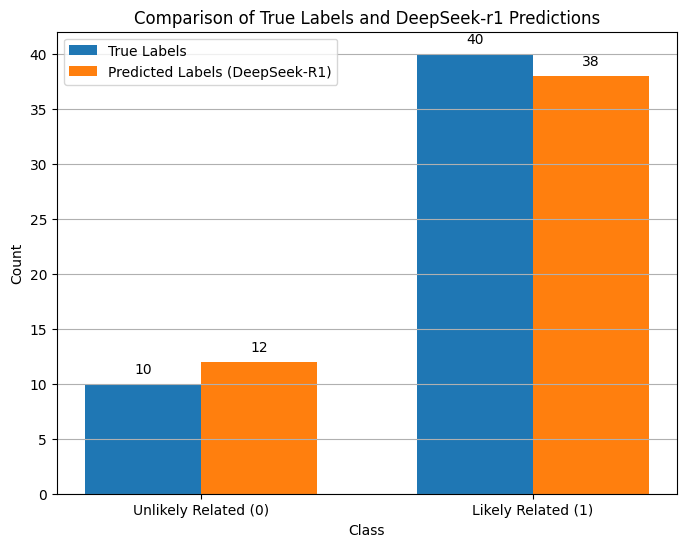

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Count values
true_counts = [np.sum(true_labels_ds == 0), np.sum(true_labels_ds == 1)]
pred_counts = [np.sum(predicted_labels == 0), np.sum(predicted_labels == 1)]

# Labels
classes = ['Unlikely Related (0)', 'Likely Related (1)']
x = np.arange(len(classes))  # the label locations
width = 0.35  # the width of the bars

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, true_counts, width, label='True Labels')
rects2 = ax.bar(x + width/2, pred_counts, width, label='Predicted Labels (DeepSeek-R1)')

# Add counts on top of bars
def add_counts(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_counts(rects1)
add_counts(rects2)

# Add labels, title, and legend
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_title('Comparison of True Labels and DeepSeek-r1 Predictions')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
plt.grid(axis='y')

plt.show()


### comparision openai vs ML vs Deepseek

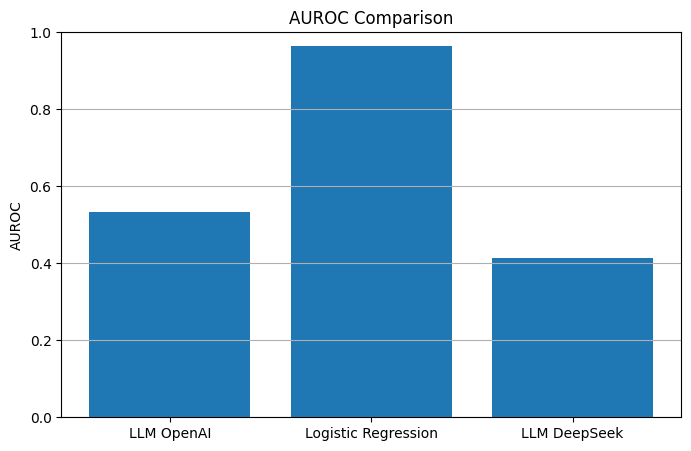

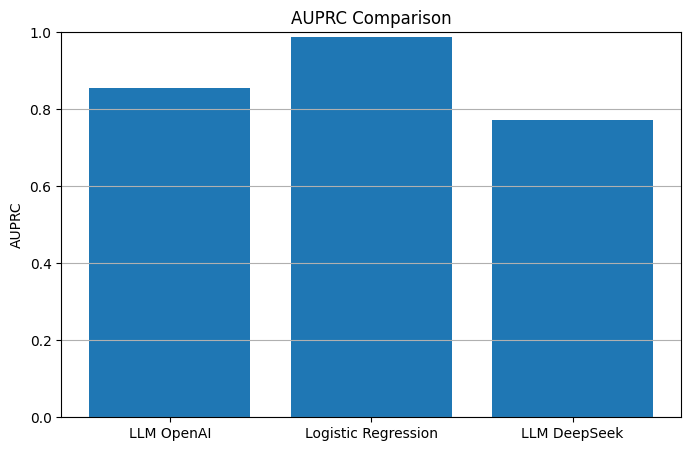

In [144]:
import matplotlib.pyplot as plt
import pandas as pd

# Given AUROC and AUPRC values (example values, you can replace them with actual numbers if available)
# auroc_llm_openai = 0.85
# auroc_lr = 0.78
# auroc_llm_deepseek = 0.88

# auprc_llm_openai = 0.83
# auprc_lr = 0.75
# auprc_llm_deepseek = 0.86

# Creating DataFrames for plotting
metrics_df = pd.DataFrame({
    'Model': ['LLM OpenAI', 'Logistic Regression', 'LLM DeepSeek'],
    'AUROC': [auroc_llm_openai, auroc, auroc_llm_deepseek],
    'AUPRC': [auprc_llm_openai, auprc, auprc_llm_deepseek]
})

# Plot AUROC
plt.figure(figsize=(8, 5))
plt.bar(metrics_df['Model'], metrics_df['AUROC'])
plt.title('AUROC Comparison')
plt.ylabel('AUROC')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# Plot AUPRC
plt.figure(figsize=(8, 5))
plt.bar(metrics_df['Model'], metrics_df['AUPRC'])
plt.title('AUPRC Comparison')
plt.ylabel('AUPRC')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

